In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,#unetr
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.6
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommend

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpkvu0ofmf


In [4]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [5]:
split_json = "dataset_1.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.32it/s]


image shape: torch.Size([1, 296, 230, 150]), label shape: torch.Size([1, 296, 230, 150])


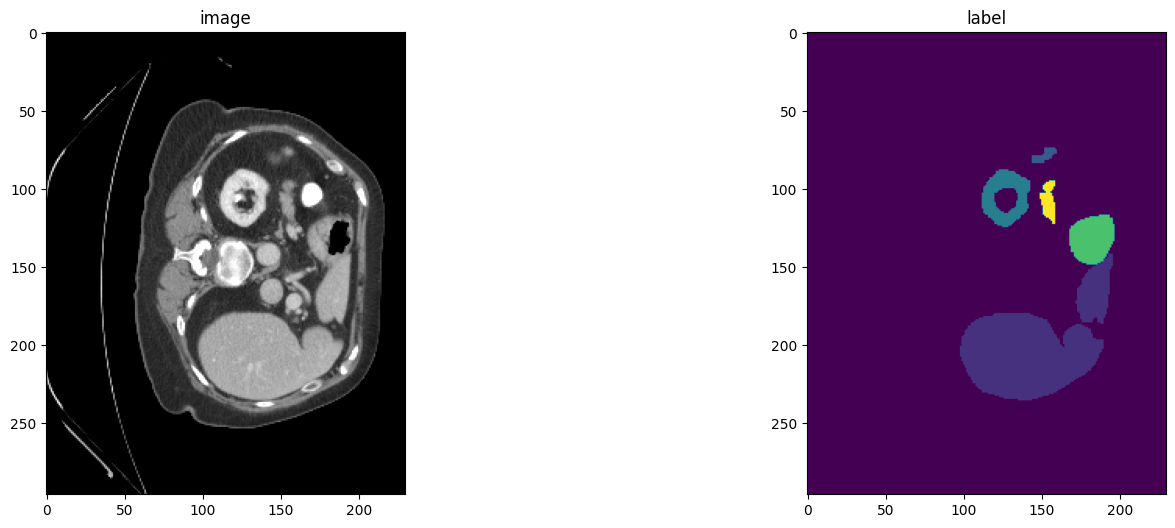

In [6]:
# slice_map = {
#     "img0035.nii.gz": 170,
#     "img0036.nii.gz": 230,
#     "img0037.nii.gz": 204,
#     "img0038.nii.gz": 204,
#     "img0039.nii.gz": 204,
#     "img0040.nii.gz": 180,
# }
slice_map = {
    "img0029.nii.gz": 90,
    "img0030.nii.gz": 230,
    "img0031.nii.gz": 204,
    "img0032.nii.gz": 204,
    "img0033.nii.gz": 204,
    "img0034.nii.gz": 180,
}
case_num = 0
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [8]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold1_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [10]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold1_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=1.76377): 100%|█| 24/24 [00:25<00:00,  1.08s/i
Training (47 / 25000 Steps) (loss=1.69925): 100%|█| 24/24 [00:21<00:00,  1.12it/
Training (71 / 25000 Steps) (loss=1.54511): 100%|█| 24/24 [00:21<00:00,  1.12it/
Training (95 / 25000 Steps) (loss=1.48414): 100%|█| 24/24 [00:21<00:00,  1.11it/
Training (119 / 25000 Steps) (loss=1.42201): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (143 / 25000 Steps) (loss=1.43475): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (167 / 25000 Steps) (loss=1.46055): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (191 / 25000 Steps) (loss=1.40517): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (215 / 25000 Steps) (loss=1.26409): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (239 / 25000 Steps) (loss=1.31061): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (263 / 25000 Steps) (loss=1.51823): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (287 / 25000 Steps) (loss=1.16039): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.22359733283519745 Current Avg. Dice: 0.22359733283519745


Training (503 / 25000 Steps) (loss=1.19881): 100%|█| 24/24 [00:35<00:00,  1.49s/
Training (527 / 25000 Steps) (loss=1.08679): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (551 / 25000 Steps) (loss=1.25036): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (575 / 25000 Steps) (loss=1.03490): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (599 / 25000 Steps) (loss=0.98285): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (623 / 25000 Steps) (loss=1.20658): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (647 / 25000 Steps) (loss=1.24281): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (671 / 25000 Steps) (loss=1.23504): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (695 / 25000 Steps) (loss=1.08429): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (719 / 25000 Steps) (loss=1.01288): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (743 / 25000 Steps) (loss=1.28922): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (767 / 25000 Steps) (loss=1.00211): 100%|█| 24/24 [00:21<00:00,  1.11it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.45375609397888184 Current Avg. Dice: 0.45375609397888184


Training (1007 / 25000 Steps) (loss=0.89837): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (1031 / 25000 Steps) (loss=1.01395): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1055 / 25000 Steps) (loss=0.90987): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1079 / 25000 Steps) (loss=0.93067): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1103 / 25000 Steps) (loss=0.97861): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1127 / 25000 Steps) (loss=0.96441): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1151 / 25000 Steps) (loss=0.94230): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1175 / 25000 Steps) (loss=1.18069): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1199 / 25000 Steps) (loss=0.99646): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1223 / 25000 Steps) (loss=1.05238): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1247 / 25000 Steps) (loss=0.83302): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1271 / 25000 Steps) (loss=0.93184): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.5786685347557068 Current Avg. Dice: 0.5786685347557068


Training (1511 / 25000 Steps) (loss=1.34641): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (1535 / 25000 Steps) (loss=0.88333): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1559 / 25000 Steps) (loss=1.15772): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1583 / 25000 Steps) (loss=0.78530): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1607 / 25000 Steps) (loss=1.07334): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1631 / 25000 Steps) (loss=0.88295): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1655 / 25000 Steps) (loss=1.07038): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1679 / 25000 Steps) (loss=0.98170): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1703 / 25000 Steps) (loss=1.00251): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1727 / 25000 Steps) (loss=0.77251): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1751 / 25000 Steps) (loss=0.85733): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1775 / 25000 Steps) (loss=1.26761): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7886541485786438 Current Avg. Dice: 0.7886541485786438


Training (2015 / 25000 Steps) (loss=0.72792): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (2039 / 25000 Steps) (loss=0.80743): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2063 / 25000 Steps) (loss=0.58182): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2087 / 25000 Steps) (loss=1.04050): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2111 / 25000 Steps) (loss=0.85501): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2135 / 25000 Steps) (loss=0.82364): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2159 / 25000 Steps) (loss=1.32060): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2183 / 25000 Steps) (loss=1.33554): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2207 / 25000 Steps) (loss=0.85864): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2231 / 25000 Steps) (loss=0.57590): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2255 / 25000 Steps) (loss=0.77391): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2279 / 25000 Steps) (loss=0.65227): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8312671184539795 Current Avg. Dice: 0.8312671184539795


Training (2519 / 25000 Steps) (loss=0.83647): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (2543 / 25000 Steps) (loss=0.87815): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2567 / 25000 Steps) (loss=0.73544): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2591 / 25000 Steps) (loss=0.85038): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2615 / 25000 Steps) (loss=0.80484): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2639 / 25000 Steps) (loss=1.11806): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2663 / 25000 Steps) (loss=0.57590): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2687 / 25000 Steps) (loss=0.73299): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2711 / 25000 Steps) (loss=0.82232): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (2735 / 25000 Steps) (loss=0.84395): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2759 / 25000 Steps) (loss=0.91327): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2783 / 25000 Steps) (loss=0.62519): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.831523597240448 Current Avg. Dice: 0.831523597240448


Training (3023 / 25000 Steps) (loss=0.80939): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (3047 / 25000 Steps) (loss=0.71474): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3071 / 25000 Steps) (loss=0.81670): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3095 / 25000 Steps) (loss=0.84875): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3119 / 25000 Steps) (loss=1.05308): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3143 / 25000 Steps) (loss=0.88930): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3167 / 25000 Steps) (loss=0.89107): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3191 / 25000 Steps) (loss=0.72049): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3215 / 25000 Steps) (loss=0.82287): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3239 / 25000 Steps) (loss=0.53309): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3263 / 25000 Steps) (loss=0.66905): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3287 / 25000 Steps) (loss=1.35818): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8348428606987 Current Avg. Dice: 0.8348428606987


Training (3503 / 25000 Steps) (loss=0.60995): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (3527 / 25000 Steps) (loss=0.50826): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3551 / 25000 Steps) (loss=0.69280): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3575 / 25000 Steps) (loss=1.44038): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3599 / 25000 Steps) (loss=0.72167): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3623 / 25000 Steps) (loss=0.52611): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3647 / 25000 Steps) (loss=0.77562): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3671 / 25000 Steps) (loss=0.99671): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3695 / 25000 Steps) (loss=0.69014): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3719 / 25000 Steps) (loss=0.83306): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3743 / 25000 Steps) (loss=1.15953): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3767 / 25000 Steps) (loss=0.73051): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8348428606987 Current Avg. Dice: 0.8206060528755188


Training (4007 / 25000 Steps) (loss=0.64718): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (4031 / 25000 Steps) (loss=0.66205): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4055 / 25000 Steps) (loss=0.63169): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4079 / 25000 Steps) (loss=0.65141): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4103 / 25000 Steps) (loss=0.73379): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4127 / 25000 Steps) (loss=0.65796): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4151 / 25000 Steps) (loss=0.56427): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4175 / 25000 Steps) (loss=0.72593): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4199 / 25000 Steps) (loss=0.73357): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4223 / 25000 Steps) (loss=1.13503): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4247 / 25000 Steps) (loss=0.88849): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4271 / 25000 Steps) (loss=0.70820): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8448919653892517 Current Avg. Dice: 0.8448919653892517


Training (4511 / 25000 Steps) (loss=0.84654): 100%|█| 24/24 [00:35<00:00,  1.50s
Training (4535 / 25000 Steps) (loss=0.78518): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4559 / 25000 Steps) (loss=0.56770): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4583 / 25000 Steps) (loss=0.86794): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4607 / 25000 Steps) (loss=0.67135): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4631 / 25000 Steps) (loss=0.64502): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4655 / 25000 Steps) (loss=0.41613): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4679 / 25000 Steps) (loss=0.97780): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4703 / 25000 Steps) (loss=0.55443): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4727 / 25000 Steps) (loss=0.66338): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4751 / 25000 Steps) (loss=0.64154): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4775 / 25000 Steps) (loss=0.77542): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8448919653892517 Current Avg. Dice: 0.8447272181510925


Training (5015 / 25000 Steps) (loss=0.74327): 100%|█| 24/24 [00:35<00:00,  1.49s
Training (5039 / 25000 Steps) (loss=0.56626): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (5063 / 25000 Steps) (loss=0.43751): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (5087 / 25000 Steps) (loss=0.62886): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5111 / 25000 Steps) (loss=0.77859): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5135 / 25000 Steps) (loss=0.64529): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5159 / 25000 Steps) (loss=0.54704): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5183 / 25000 Steps) (loss=0.62877): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5207 / 25000 Steps) (loss=0.66760): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5231 / 25000 Steps) (loss=0.67529): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5255 / 25000 Steps) (loss=0.64434): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5279 / 25000 Steps) (loss=0.62333): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8448919653892517 Current Avg. Dice: 0.8387651443481445


Training (5519 / 25000 Steps) (loss=0.58781): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (5543 / 25000 Steps) (loss=0.58814): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5567 / 25000 Steps) (loss=0.81595): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5591 / 25000 Steps) (loss=0.62493): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5615 / 25000 Steps) (loss=0.72503): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5639 / 25000 Steps) (loss=0.72747): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5663 / 25000 Steps) (loss=0.65120): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5687 / 25000 Steps) (loss=0.55523): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5711 / 25000 Steps) (loss=0.64070): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5735 / 25000 Steps) (loss=0.69585): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5759 / 25000 Steps) (loss=0.56047): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5783 / 25000 Steps) (loss=0.53064): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8573529124259949 Current Avg. Dice: 0.8573529124259949


Training (6023 / 25000 Steps) (loss=0.66070): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (6047 / 25000 Steps) (loss=0.83434): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6071 / 25000 Steps) (loss=0.65498): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6095 / 25000 Steps) (loss=0.75414): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6119 / 25000 Steps) (loss=0.68661): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6143 / 25000 Steps) (loss=0.70809): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6167 / 25000 Steps) (loss=0.50470): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6191 / 25000 Steps) (loss=0.53978): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6215 / 25000 Steps) (loss=0.51096): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6239 / 25000 Steps) (loss=0.54283): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6263 / 25000 Steps) (loss=0.73434): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6287 / 25000 Steps) (loss=0.58107): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8718082904815674 Current Avg. Dice: 0.8718082904815674


Training (6503 / 25000 Steps) (loss=0.56553): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (6527 / 25000 Steps) (loss=0.48693): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6551 / 25000 Steps) (loss=0.44705): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6575 / 25000 Steps) (loss=0.56700): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6599 / 25000 Steps) (loss=0.74451): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6623 / 25000 Steps) (loss=0.55304): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6647 / 25000 Steps) (loss=0.59682): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6671 / 25000 Steps) (loss=0.64889): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6695 / 25000 Steps) (loss=0.45210): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6719 / 25000 Steps) (loss=0.49012): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6743 / 25000 Steps) (loss=0.67072): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6767 / 25000 Steps) (loss=0.56364): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8718082904815674 Current Avg. Dice: 0.8631389737129211


Training (7007 / 25000 Steps) (loss=0.65898): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (7031 / 25000 Steps) (loss=0.40193): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7055 / 25000 Steps) (loss=0.60719): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7079 / 25000 Steps) (loss=0.59457): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7103 / 25000 Steps) (loss=0.93007): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7127 / 25000 Steps) (loss=0.66885): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7151 / 25000 Steps) (loss=0.51151): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7175 / 25000 Steps) (loss=0.43345): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7199 / 25000 Steps) (loss=1.24682): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7223 / 25000 Steps) (loss=0.76401): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7247 / 25000 Steps) (loss=0.63901): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7271 / 25000 Steps) (loss=0.48337): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8718082904815674 Current Avg. Dice: 0.86004239320755


Training (7511 / 25000 Steps) (loss=0.59248): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (7535 / 25000 Steps) (loss=0.84113): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7559 / 25000 Steps) (loss=0.59465): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7583 / 25000 Steps) (loss=0.69136): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7607 / 25000 Steps) (loss=0.67377): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7631 / 25000 Steps) (loss=0.59099): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7655 / 25000 Steps) (loss=0.74333): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7679 / 25000 Steps) (loss=0.46981): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7703 / 25000 Steps) (loss=0.66987): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7727 / 25000 Steps) (loss=1.30236): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7751 / 25000 Steps) (loss=0.54224): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7775 / 25000 Steps) (loss=0.74513): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8718082904815674 Current Avg. Dice: 0.8700764775276184


Training (8015 / 25000 Steps) (loss=0.76283): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (8039 / 25000 Steps) (loss=0.61216): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8063 / 25000 Steps) (loss=0.72312): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8087 / 25000 Steps) (loss=0.53135): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8111 / 25000 Steps) (loss=0.64139): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8135 / 25000 Steps) (loss=0.63153): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8159 / 25000 Steps) (loss=0.72917): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8183 / 25000 Steps) (loss=0.52715): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8207 / 25000 Steps) (loss=0.65473): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8231 / 25000 Steps) (loss=0.61369): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8255 / 25000 Steps) (loss=0.68928): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8279 / 25000 Steps) (loss=0.51293): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8718082904815674 Current Avg. Dice: 0.8592793345451355


Training (8519 / 25000 Steps) (loss=0.64244): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (8543 / 25000 Steps) (loss=0.54261): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8567 / 25000 Steps) (loss=0.76589): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8591 / 25000 Steps) (loss=0.54008): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8615 / 25000 Steps) (loss=0.63367): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8639 / 25000 Steps) (loss=0.73772): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8663 / 25000 Steps) (loss=0.72642): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8687 / 25000 Steps) (loss=0.55955): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8711 / 25000 Steps) (loss=0.61074): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8735 / 25000 Steps) (loss=0.55113): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8759 / 25000 Steps) (loss=0.68002): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8783 / 25000 Steps) (loss=0.66444): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (8807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8796477913856506 Current Avg. Dice: 0.8796477913856506


Training (9023 / 25000 Steps) (loss=0.78118): 100%|█| 24/24 [00:35<00:00,  1.48s
Training (9047 / 25000 Steps) (loss=0.55624): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9071 / 25000 Steps) (loss=0.70571): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (9095 / 25000 Steps) (loss=0.55321): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9119 / 25000 Steps) (loss=0.47533): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9143 / 25000 Steps) (loss=0.61054): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9167 / 25000 Steps) (loss=0.50454): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9191 / 25000 Steps) (loss=0.56507): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9215 / 25000 Steps) (loss=0.92303): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9239 / 25000 Steps) (loss=0.70959): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9263 / 25000 Steps) (loss=0.69492): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9287 / 25000 Steps) (loss=0.61719): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8796477913856506 Current Avg. Dice: 0.8769615292549133


Training (9503 / 25000 Steps) (loss=0.50107): 100%|█| 24/24 [00:35<00:00,  1.47s
Training (9527 / 25000 Steps) (loss=0.60315): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9551 / 25000 Steps) (loss=0.85117): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9575 / 25000 Steps) (loss=0.51330): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9599 / 25000 Steps) (loss=0.48694): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9623 / 25000 Steps) (loss=0.35245): 100%|█| 24/24 [00:21<00:00,  1.11i
Training (9647 / 25000 Steps) (loss=0.72747): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9671 / 25000 Steps) (loss=0.48892): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9695 / 25000 Steps) (loss=0.63285): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9719 / 25000 Steps) (loss=0.40366): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9743 / 25000 Steps) (loss=0.68446): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9767 / 25000 Steps) (loss=0.76971): 100%|█| 24/24 [00:21<00:00,  1.12i
Training (9791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8796477913856506 Current Avg. Dice: 0.8725442886352539


Training (10007 / 25000 Steps) (loss=0.46103): 100%|█| 24/24 [00:35<00:00,  1.47
Training (10031 / 25000 Steps) (loss=0.57092): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10055 / 25000 Steps) (loss=0.88412): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10079 / 25000 Steps) (loss=0.73052): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10103 / 25000 Steps) (loss=0.59324): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10127 / 25000 Steps) (loss=0.53730): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10151 / 25000 Steps) (loss=0.66505): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10175 / 25000 Steps) (loss=0.79907): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10199 / 25000 Steps) (loss=0.33684): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10223 / 25000 Steps) (loss=0.53766): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10247 / 25000 Steps) (loss=0.75627): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10271 / 25000 Steps) (loss=0.65542): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8796477913856506 Current Avg. Dice: 0.8629958033561707


Training (10511 / 25000 Steps) (loss=0.70054): 100%|█| 24/24 [00:35<00:00,  1.47
Training (10535 / 25000 Steps) (loss=0.59390): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10559 / 25000 Steps) (loss=0.53947): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10583 / 25000 Steps) (loss=0.63300): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10607 / 25000 Steps) (loss=0.68297): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10631 / 25000 Steps) (loss=0.49050): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10655 / 25000 Steps) (loss=0.60797): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10679 / 25000 Steps) (loss=0.65949): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10703 / 25000 Steps) (loss=0.66517): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10727 / 25000 Steps) (loss=0.70223): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10751 / 25000 Steps) (loss=0.73948): 100%|█| 24/24 [00:21<00:00,  1.11
Training (10775 / 25000 Steps) (loss=0.46380): 100%|█| 24/24 [00:21<00:00,  1.12
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8796477913856506 Current Avg. Dice: 0.8621394038200378


Training (11015 / 25000 Steps) (loss=0.68996): 100%|█| 24/24 [00:35<00:00,  1.47
Training (11039 / 25000 Steps) (loss=0.61527): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11063 / 25000 Steps) (loss=0.74930): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11087 / 25000 Steps) (loss=0.88198): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11111 / 25000 Steps) (loss=0.65401): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11135 / 25000 Steps) (loss=0.79684): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11159 / 25000 Steps) (loss=0.47417): 100%|█| 24/24 [00:21<00:00,  1.11
Training (11183 / 25000 Steps) (loss=0.35384): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11207 / 25000 Steps) (loss=0.52277): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11231 / 25000 Steps) (loss=0.63107): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11255 / 25000 Steps) (loss=0.39578): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11279 / 25000 Steps) (loss=0.72957): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8796477913856506 Current Avg. Dice: 0.855206310749054


Training (11519 / 25000 Steps) (loss=0.74074): 100%|█| 24/24 [00:35<00:00,  1.47
Training (11543 / 25000 Steps) (loss=0.49681): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11567 / 25000 Steps) (loss=0.41468): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11591 / 25000 Steps) (loss=0.57575): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11615 / 25000 Steps) (loss=0.74458): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11639 / 25000 Steps) (loss=0.56137): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11663 / 25000 Steps) (loss=0.48379): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11687 / 25000 Steps) (loss=0.48776): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11711 / 25000 Steps) (loss=0.63039): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11735 / 25000 Steps) (loss=0.52746): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11759 / 25000 Steps) (loss=0.54703): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11783 / 25000 Steps) (loss=0.41936): 100%|█| 24/24 [00:21<00:00,  1.12
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8796477913856506 Current Avg. Dice: 0.8793738484382629


Training (12023 / 25000 Steps) (loss=0.63887): 100%|█| 24/24 [00:35<00:00,  1.47
Training (12047 / 25000 Steps) (loss=0.66821): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12071 / 25000 Steps) (loss=0.50277): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12095 / 25000 Steps) (loss=0.69644): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12119 / 25000 Steps) (loss=0.73287): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12143 / 25000 Steps) (loss=0.64213): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12167 / 25000 Steps) (loss=0.61773): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12191 / 25000 Steps) (loss=0.42713): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12215 / 25000 Steps) (loss=0.46836): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12239 / 25000 Steps) (loss=0.65958): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12263 / 25000 Steps) (loss=0.65773): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12287 / 25000 Steps) (loss=0.35411): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12311 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8824748992919922


Training (12503 / 25000 Steps) (loss=0.63490): 100%|█| 24/24 [00:35<00:00,  1.48
Training (12527 / 25000 Steps) (loss=0.62795): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12551 / 25000 Steps) (loss=0.54550): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12575 / 25000 Steps) (loss=0.60823): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12599 / 25000 Steps) (loss=0.54160): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12623 / 25000 Steps) (loss=0.58196): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12647 / 25000 Steps) (loss=0.43389): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12671 / 25000 Steps) (loss=0.56385): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12695 / 25000 Steps) (loss=0.77482): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12719 / 25000 Steps) (loss=0.56231): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12743 / 25000 Steps) (loss=0.64032): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12767 / 25000 Steps) (loss=0.57647): 100%|█| 24/24 [00:21<00:00,  1.12
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8723929524421692


Training (13007 / 25000 Steps) (loss=0.66753): 100%|█| 24/24 [00:35<00:00,  1.47
Training (13031 / 25000 Steps) (loss=0.69158): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13055 / 25000 Steps) (loss=0.23941): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13079 / 25000 Steps) (loss=0.66567): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13103 / 25000 Steps) (loss=0.62920): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13127 / 25000 Steps) (loss=0.60702): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13151 / 25000 Steps) (loss=0.44113): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13175 / 25000 Steps) (loss=0.47727): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13199 / 25000 Steps) (loss=0.58739): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13223 / 25000 Steps) (loss=0.62747): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13247 / 25000 Steps) (loss=0.57705): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13271 / 25000 Steps) (loss=0.54779): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8491366505622864


Training (13511 / 25000 Steps) (loss=0.67838): 100%|█| 24/24 [00:35<00:00,  1.47
Training (13535 / 25000 Steps) (loss=0.74062): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13559 / 25000 Steps) (loss=0.68623): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13583 / 25000 Steps) (loss=0.49140): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13607 / 25000 Steps) (loss=0.56578): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13631 / 25000 Steps) (loss=0.65629): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13655 / 25000 Steps) (loss=0.60231): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13679 / 25000 Steps) (loss=0.47323): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13703 / 25000 Steps) (loss=0.77052): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13727 / 25000 Steps) (loss=0.67128): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13751 / 25000 Steps) (loss=0.72963): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13775 / 25000 Steps) (loss=0.62262): 100%|█| 24/24 [00:21<00:00,  1.12
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8754007816314697


Training (14015 / 25000 Steps) (loss=0.59570): 100%|█| 24/24 [00:35<00:00,  1.47
Training (14039 / 25000 Steps) (loss=0.60965): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14063 / 25000 Steps) (loss=0.59744): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14087 / 25000 Steps) (loss=0.70144): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14111 / 25000 Steps) (loss=0.70772): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14135 / 25000 Steps) (loss=0.37307): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14159 / 25000 Steps) (loss=0.60523): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14183 / 25000 Steps) (loss=0.66059): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14207 / 25000 Steps) (loss=0.53281): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14231 / 25000 Steps) (loss=0.37820): 100%|█| 24/24 [00:21<00:00,  1.11
Training (14255 / 25000 Steps) (loss=0.62488): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14279 / 25000 Steps) (loss=0.66736): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8513550758361816


Training (14519 / 25000 Steps) (loss=0.49084): 100%|█| 24/24 [00:35<00:00,  1.47
Training (14543 / 25000 Steps) (loss=0.62693): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14567 / 25000 Steps) (loss=0.63458): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14591 / 25000 Steps) (loss=0.64534): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14615 / 25000 Steps) (loss=1.00864): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14639 / 25000 Steps) (loss=0.52427): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14663 / 25000 Steps) (loss=0.51089): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14687 / 25000 Steps) (loss=0.38306): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14711 / 25000 Steps) (loss=0.47903): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14735 / 25000 Steps) (loss=0.45983): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14759 / 25000 Steps) (loss=0.54195): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14783 / 25000 Steps) (loss=0.56429): 100%|█| 24/24 [00:21<00:00,  1.12
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8548514246940613


Training (15023 / 25000 Steps) (loss=0.66177): 100%|█| 24/24 [00:35<00:00,  1.47
Training (15047 / 25000 Steps) (loss=0.67483): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15071 / 25000 Steps) (loss=0.54273): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15095 / 25000 Steps) (loss=0.66436): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15119 / 25000 Steps) (loss=0.59744): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15143 / 25000 Steps) (loss=0.69644): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15167 / 25000 Steps) (loss=0.70441): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15191 / 25000 Steps) (loss=0.61511): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15215 / 25000 Steps) (loss=0.63348): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15239 / 25000 Steps) (loss=0.46909): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15263 / 25000 Steps) (loss=0.39421): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15287 / 25000 Steps) (loss=0.62241): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8603372573852539


Training (15503 / 25000 Steps) (loss=0.58505): 100%|█| 24/24 [00:35<00:00,  1.47
Training (15527 / 25000 Steps) (loss=0.60567): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15551 / 25000 Steps) (loss=0.40859): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15575 / 25000 Steps) (loss=0.45062): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15599 / 25000 Steps) (loss=0.67027): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15623 / 25000 Steps) (loss=0.75687): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15647 / 25000 Steps) (loss=0.45835): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15671 / 25000 Steps) (loss=0.67892): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15695 / 25000 Steps) (loss=0.40631): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15719 / 25000 Steps) (loss=0.83467): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15743 / 25000 Steps) (loss=0.57911): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15767 / 25000 Steps) (loss=0.74160): 100%|█| 24/24 [00:21<00:00,  1.12
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8593871593475342


Training (16007 / 25000 Steps) (loss=0.69219): 100%|█| 24/24 [00:35<00:00,  1.47
Training (16031 / 25000 Steps) (loss=0.52550): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16055 / 25000 Steps) (loss=0.89268): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16079 / 25000 Steps) (loss=0.72751): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16103 / 25000 Steps) (loss=0.62907): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16127 / 25000 Steps) (loss=0.52769): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16151 / 25000 Steps) (loss=0.48024): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16175 / 25000 Steps) (loss=0.48237): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16199 / 25000 Steps) (loss=0.44716): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16223 / 25000 Steps) (loss=0.76015): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16247 / 25000 Steps) (loss=0.56612): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16271 / 25000 Steps) (loss=0.61560): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8738389015197754


Training (16511 / 25000 Steps) (loss=0.65901): 100%|█| 24/24 [00:35<00:00,  1.47
Training (16535 / 25000 Steps) (loss=0.75551): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16559 / 25000 Steps) (loss=0.73164): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16583 / 25000 Steps) (loss=0.65945): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16607 / 25000 Steps) (loss=0.65071): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16631 / 25000 Steps) (loss=0.57284): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16655 / 25000 Steps) (loss=0.63713): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16679 / 25000 Steps) (loss=0.45441): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16703 / 25000 Steps) (loss=0.61280): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16727 / 25000 Steps) (loss=0.62834): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16751 / 25000 Steps) (loss=0.47538): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16775 / 25000 Steps) (loss=0.70122): 100%|█| 24/24 [00:21<00:00,  1.12
Training (16799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8661990165710449


Training (17015 / 25000 Steps) (loss=0.63308): 100%|█| 24/24 [00:35<00:00,  1.47
Training (17039 / 25000 Steps) (loss=0.57689): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17063 / 25000 Steps) (loss=0.70189): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17087 / 25000 Steps) (loss=0.78818): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17111 / 25000 Steps) (loss=0.45284): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17135 / 25000 Steps) (loss=0.57359): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17159 / 25000 Steps) (loss=0.54896): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17183 / 25000 Steps) (loss=0.63506): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17207 / 25000 Steps) (loss=0.52015): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17231 / 25000 Steps) (loss=0.63616): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17255 / 25000 Steps) (loss=0.77581): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17279 / 25000 Steps) (loss=0.36200): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8824748992919922 Current Avg. Dice: 0.8563148975372314


Training (17519 / 25000 Steps) (loss=0.51263): 100%|█| 24/24 [00:35<00:00,  1.47
Training (17543 / 25000 Steps) (loss=0.42745): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17567 / 25000 Steps) (loss=0.47970): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17591 / 25000 Steps) (loss=0.55295): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17615 / 25000 Steps) (loss=0.67937): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17639 / 25000 Steps) (loss=0.52990): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17663 / 25000 Steps) (loss=0.61713): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17687 / 25000 Steps) (loss=0.52437): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17711 / 25000 Steps) (loss=0.59135): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17735 / 25000 Steps) (loss=0.54327): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17759 / 25000 Steps) (loss=0.44039): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17783 / 25000 Steps) (loss=0.66436): 100%|█| 24/24 [00:21<00:00,  1.12
Training (17807 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8889307975769043 Current Avg. Dice: 0.8889307975769043


Training (18023 / 25000 Steps) (loss=0.49733): 100%|█| 24/24 [00:35<00:00,  1.48
Training (18047 / 25000 Steps) (loss=0.51227): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18071 / 25000 Steps) (loss=0.50679): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18095 / 25000 Steps) (loss=0.55478): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18119 / 25000 Steps) (loss=0.55087): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18143 / 25000 Steps) (loss=0.50099): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18167 / 25000 Steps) (loss=0.81506): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18191 / 25000 Steps) (loss=0.66416): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18215 / 25000 Steps) (loss=0.62014): 100%|█| 24/24 [00:21<00:00,  1.11
Training (18239 / 25000 Steps) (loss=0.38721): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18263 / 25000 Steps) (loss=0.65332): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18287 / 25000 Steps) (loss=0.33055): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8889307975769043 Current Avg. Dice: 0.8746464252471924


Training (18503 / 25000 Steps) (loss=0.50058): 100%|█| 24/24 [00:35<00:00,  1.47
Training (18527 / 25000 Steps) (loss=0.50698): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18551 / 25000 Steps) (loss=0.55812): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18575 / 25000 Steps) (loss=0.57272): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18599 / 25000 Steps) (loss=0.56120): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18623 / 25000 Steps) (loss=0.54415): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18647 / 25000 Steps) (loss=0.32339): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18671 / 25000 Steps) (loss=0.86660): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18695 / 25000 Steps) (loss=0.48486): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18719 / 25000 Steps) (loss=0.72858): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18743 / 25000 Steps) (loss=0.59489): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18767 / 25000 Steps) (loss=0.39189): 100%|█| 24/24 [00:21<00:00,  1.12
Training (18791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8889307975769043 Current Avg. Dice: 0.8719795346260071


Training (19007 / 25000 Steps) (loss=0.79360): 100%|█| 24/24 [00:35<00:00,  1.47
Training (19031 / 25000 Steps) (loss=0.29698): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19055 / 25000 Steps) (loss=0.67254): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19079 / 25000 Steps) (loss=0.56778): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19103 / 25000 Steps) (loss=0.34946): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19127 / 25000 Steps) (loss=0.67586): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19151 / 25000 Steps) (loss=0.35379): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19175 / 25000 Steps) (loss=0.53168): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19199 / 25000 Steps) (loss=0.59913): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19223 / 25000 Steps) (loss=0.52564): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19247 / 25000 Steps) (loss=0.50964): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19271 / 25000 Steps) (loss=0.50909): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8889307975769043 Current Avg. Dice: 0.8676164746284485


Training (19511 / 25000 Steps) (loss=0.46068): 100%|█| 24/24 [00:35<00:00,  1.47
Training (19535 / 25000 Steps) (loss=0.68965): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19559 / 25000 Steps) (loss=0.50267): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19583 / 25000 Steps) (loss=0.73413): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19607 / 25000 Steps) (loss=0.56844): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19631 / 25000 Steps) (loss=0.48476): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19655 / 25000 Steps) (loss=0.47720): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19679 / 25000 Steps) (loss=0.53578): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19703 / 25000 Steps) (loss=0.53852): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19727 / 25000 Steps) (loss=0.48652): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19751 / 25000 Steps) (loss=0.66609): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19775 / 25000 Steps) (loss=0.65996): 100%|█| 24/24 [00:21<00:00,  1.12
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8889307975769043 Current Avg. Dice: 0.852479875087738


Training (20015 / 25000 Steps) (loss=0.61589): 100%|█| 24/24 [00:35<00:00,  1.47
Training (20039 / 25000 Steps) (loss=0.43758): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20063 / 25000 Steps) (loss=0.59514): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20087 / 25000 Steps) (loss=0.74983): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20111 / 25000 Steps) (loss=0.56957): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20135 / 25000 Steps) (loss=0.64625): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20159 / 25000 Steps) (loss=0.40698): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20183 / 25000 Steps) (loss=0.61726): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20207 / 25000 Steps) (loss=0.44409): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20231 / 25000 Steps) (loss=0.73880): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20255 / 25000 Steps) (loss=0.59257): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20279 / 25000 Steps) (loss=0.48064): 100%|█| 24/24 [00:21<00:00,  1.12
Training (20303 / 25000 Step

KeyboardInterrupt: 

In [11]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8812 at iteration: 24000


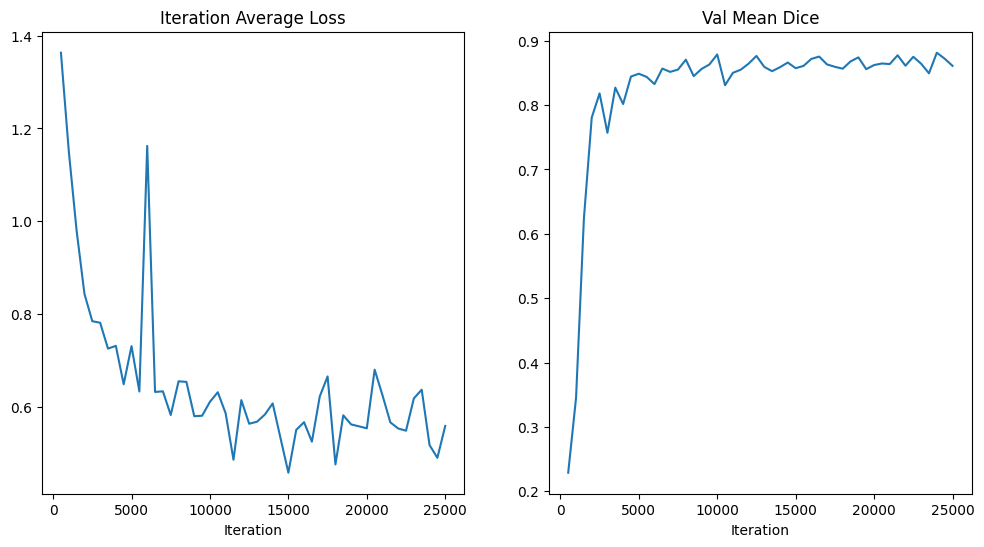

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

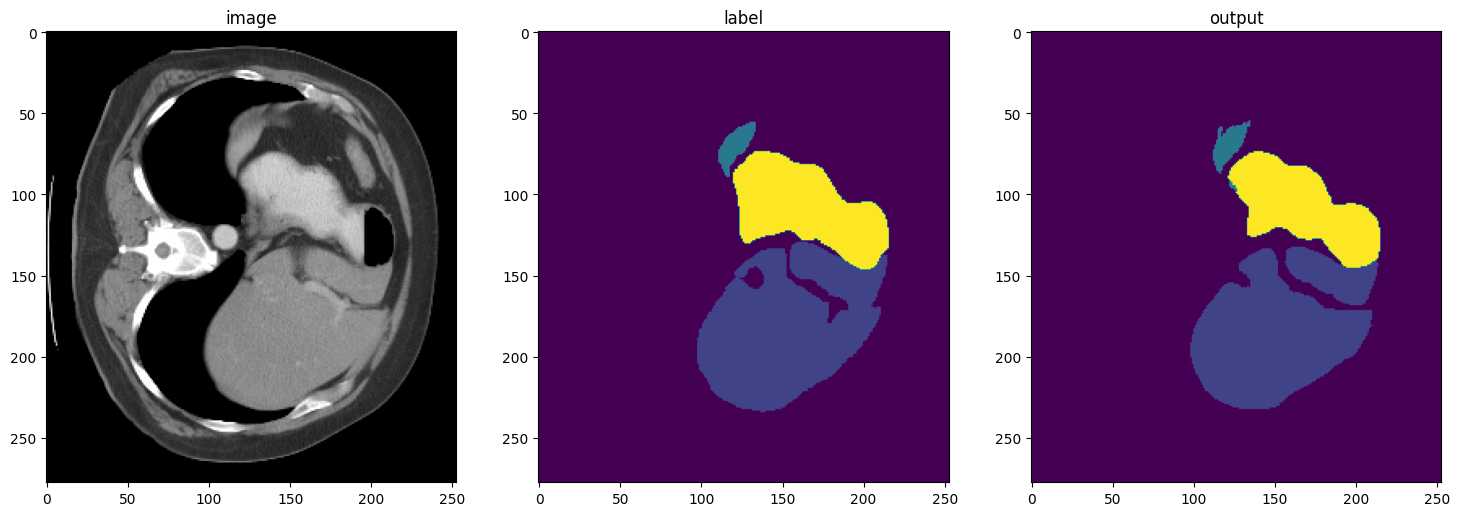

In [13]:
case_num = 4
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_fold1_best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()

In [5]:
split_json = "dataset_random_split.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|████████████████████████████| 6/6 [00:04<00:00,  1.21it/s]


In [6]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [7]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [8]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join("/home/user/Documents/swin_unetr", "swinunetr_dicece_best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [9]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=8)
post_pred = AsDiscrete(argmax=True, to_onehot=8)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join("/home/user/Documents/swin_unetr", "swinunetr_dicece_best_metric_model.pth")))

Training (23 / 25000 Steps) (loss=1.90519): 100%|█| 24/24 [00:23<00:00,  1.02it/
Training (47 / 25000 Steps) (loss=1.96268): 100%|█| 24/24 [00:18<00:00,  1.28it/
Training (71 / 25000 Steps) (loss=1.92293): 100%|█| 24/24 [00:18<00:00,  1.27it/
Training (95 / 25000 Steps) (loss=1.69168): 100%|█| 24/24 [00:18<00:00,  1.27it/
Training (119 / 25000 Steps) (loss=1.67657): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (143 / 25000 Steps) (loss=1.53261): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (167 / 25000 Steps) (loss=1.42821): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (191 / 25000 Steps) (loss=1.53897): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (215 / 25000 Steps) (loss=1.31743): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (239 / 25000 Steps) (loss=1.38656): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (263 / 25000 Steps) (loss=1.24865): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (287 / 25000 Steps) (loss=1.33595): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (311 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.2352004498243332 Current Avg. Dice: 0.2352004498243332


Training (503 / 25000 Steps) (loss=1.15312): 100%|█| 24/24 [00:32<00:00,  1.35s/
Training (527 / 25000 Steps) (loss=1.23267): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (551 / 25000 Steps) (loss=1.18724): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (575 / 25000 Steps) (loss=1.25858): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (599 / 25000 Steps) (loss=1.24584): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (623 / 25000 Steps) (loss=1.23394): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (647 / 25000 Steps) (loss=1.29334): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (671 / 25000 Steps) (loss=1.26404): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (695 / 25000 Steps) (loss=1.10036): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (719 / 25000 Steps) (loss=1.07546): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (743 / 25000 Steps) (loss=1.08312): 100%|█| 24/24 [00:18<00:00,  1.27it
Training (767 / 25000 Steps) (loss=1.31740): 100%|█| 24/24 [00:18<00:00,  1.28it
Training (791 / 25000 Steps)

Model Was Saved ! Current Best Avg. Dice: 0.4036211669445038 Current Avg. Dice: 0.4036211669445038


Training (1007 / 25000 Steps) (loss=0.99995): 100%|█| 24/24 [00:30<00:00,  1.28s
Training (1031 / 25000 Steps) (loss=1.04292): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1055 / 25000 Steps) (loss=0.98552): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1079 / 25000 Steps) (loss=1.03011): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1103 / 25000 Steps) (loss=1.06471): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1127 / 25000 Steps) (loss=1.00854): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1151 / 25000 Steps) (loss=1.25092): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1175 / 25000 Steps) (loss=0.93415): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1199 / 25000 Steps) (loss=0.91740): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1223 / 25000 Steps) (loss=0.87931): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1247 / 25000 Steps) (loss=0.80927): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1271 / 25000 Steps) (loss=0.94864): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.6859843134880066 Current Avg. Dice: 0.6859843134880066


Training (1511 / 25000 Steps) (loss=0.94062): 100%|█| 24/24 [00:30<00:00,  1.28s
Training (1535 / 25000 Steps) (loss=1.07272): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1559 / 25000 Steps) (loss=0.93044): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1583 / 25000 Steps) (loss=0.99309): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1607 / 25000 Steps) (loss=1.39993): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1631 / 25000 Steps) (loss=1.03084): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1655 / 25000 Steps) (loss=0.71820): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1679 / 25000 Steps) (loss=0.94356): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1703 / 25000 Steps) (loss=0.72771): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1727 / 25000 Steps) (loss=0.77171): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1751 / 25000 Steps) (loss=1.00843): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (1775 / 25000 Steps) (loss=0.95169): 100%|█| 24/24 [00:18<00:00,  1.27i
Training (1799 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7188553810119629 Current Avg. Dice: 0.7188553810119629


Training (2015 / 25000 Steps) (loss=1.03962): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (2039 / 25000 Steps) (loss=0.70782): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2063 / 25000 Steps) (loss=0.74909): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2087 / 25000 Steps) (loss=0.66649): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2111 / 25000 Steps) (loss=0.77416): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2135 / 25000 Steps) (loss=0.79067): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2159 / 25000 Steps) (loss=0.80576): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2183 / 25000 Steps) (loss=0.74002): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2207 / 25000 Steps) (loss=0.71917): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2231 / 25000 Steps) (loss=0.69787): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2255 / 25000 Steps) (loss=0.67981): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2279 / 25000 Steps) (loss=0.72185): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2303 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.782008945941925 Current Avg. Dice: 0.782008945941925


Training (2519 / 25000 Steps) (loss=0.81738): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (2543 / 25000 Steps) (loss=0.73100): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2567 / 25000 Steps) (loss=0.69196): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2591 / 25000 Steps) (loss=0.65550): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2615 / 25000 Steps) (loss=0.81605): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2639 / 25000 Steps) (loss=0.49237): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2663 / 25000 Steps) (loss=0.83842): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2687 / 25000 Steps) (loss=0.66067): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2711 / 25000 Steps) (loss=0.67455): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2735 / 25000 Steps) (loss=0.61314): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2759 / 25000 Steps) (loss=0.77323): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2783 / 25000 Steps) (loss=0.73089): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (2807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.7840511202812195 Current Avg. Dice: 0.7840511202812195


Training (3023 / 25000 Steps) (loss=0.63937): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (3047 / 25000 Steps) (loss=0.58309): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3071 / 25000 Steps) (loss=0.72444): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3095 / 25000 Steps) (loss=0.67203): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3119 / 25000 Steps) (loss=0.71801): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3143 / 25000 Steps) (loss=0.52366): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3167 / 25000 Steps) (loss=0.60691): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3191 / 25000 Steps) (loss=0.77895): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3215 / 25000 Steps) (loss=0.64913): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3239 / 25000 Steps) (loss=0.67374): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3263 / 25000 Steps) (loss=0.64730): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3287 / 25000 Steps) (loss=0.75251): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3311 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8024380803108215 Current Avg. Dice: 0.8024380803108215


Training (3503 / 25000 Steps) (loss=0.69306): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (3527 / 25000 Steps) (loss=0.71667): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3551 / 25000 Steps) (loss=0.76569): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3575 / 25000 Steps) (loss=0.75227): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3599 / 25000 Steps) (loss=0.71052): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3623 / 25000 Steps) (loss=0.71520): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3647 / 25000 Steps) (loss=0.67883): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3671 / 25000 Steps) (loss=0.76838): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3695 / 25000 Steps) (loss=0.70777): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3719 / 25000 Steps) (loss=0.62032): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3743 / 25000 Steps) (loss=0.90459): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3767 / 25000 Steps) (loss=0.75959): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (3791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8024380803108215 Current Avg. Dice: 0.777289092540741


Training (4007 / 25000 Steps) (loss=0.84663): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (4031 / 25000 Steps) (loss=0.62526): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4055 / 25000 Steps) (loss=0.80125): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4079 / 25000 Steps) (loss=0.65958): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4103 / 25000 Steps) (loss=0.72022): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4127 / 25000 Steps) (loss=0.66606): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4151 / 25000 Steps) (loss=0.55690): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4175 / 25000 Steps) (loss=0.68919): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4199 / 25000 Steps) (loss=0.67562): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4223 / 25000 Steps) (loss=1.06179): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4247 / 25000 Steps) (loss=0.70826): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4271 / 25000 Steps) (loss=0.71942): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4295 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8116896748542786 Current Avg. Dice: 0.8116896748542786


Training (4511 / 25000 Steps) (loss=0.69430): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (4535 / 25000 Steps) (loss=0.61739): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4559 / 25000 Steps) (loss=0.47743): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4583 / 25000 Steps) (loss=0.64059): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4607 / 25000 Steps) (loss=0.69587): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (4631 / 25000 Steps) (loss=0.71372): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4655 / 25000 Steps) (loss=0.60739): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4679 / 25000 Steps) (loss=0.78016): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4703 / 25000 Steps) (loss=0.75503): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4727 / 25000 Steps) (loss=0.74708): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4751 / 25000 Steps) (loss=0.49016): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4775 / 25000 Steps) (loss=0.65790): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (4799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8116896748542786 Current Avg. Dice: 0.77374666929245


Training (5015 / 25000 Steps) (loss=0.62088): 100%|█| 24/24 [00:29<00:00,  1.24s
Training (5039 / 25000 Steps) (loss=0.63277): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5063 / 25000 Steps) (loss=0.80319): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5087 / 25000 Steps) (loss=0.72060): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5111 / 25000 Steps) (loss=0.62362): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5135 / 25000 Steps) (loss=0.37087): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5159 / 25000 Steps) (loss=0.87859): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5183 / 25000 Steps) (loss=0.59341): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5207 / 25000 Steps) (loss=1.14901): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5231 / 25000 Steps) (loss=0.75418): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (5255 / 25000 Steps) (loss=0.34471): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5279 / 25000 Steps) (loss=0.77345): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8116896748542786 Current Avg. Dice: 0.757617175579071


Training (5519 / 25000 Steps) (loss=0.45006): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (5543 / 25000 Steps) (loss=0.54947): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5567 / 25000 Steps) (loss=0.57281): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5591 / 25000 Steps) (loss=0.69250): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5615 / 25000 Steps) (loss=0.46820): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5639 / 25000 Steps) (loss=0.69361): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5663 / 25000 Steps) (loss=0.50028): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5687 / 25000 Steps) (loss=0.68969): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5711 / 25000 Steps) (loss=0.67647): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5735 / 25000 Steps) (loss=0.40108): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5759 / 25000 Steps) (loss=0.54193): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5783 / 25000 Steps) (loss=0.68079): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (5807 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8237753510475159 Current Avg. Dice: 0.8237753510475159


Training (6023 / 25000 Steps) (loss=0.56993): 100%|█| 24/24 [00:30<00:00,  1.26s
Training (6047 / 25000 Steps) (loss=0.84881): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6071 / 25000 Steps) (loss=0.53524): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6095 / 25000 Steps) (loss=0.84512): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6119 / 25000 Steps) (loss=0.60986): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6143 / 25000 Steps) (loss=0.41014): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (6167 / 25000 Steps) (loss=0.60954): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6191 / 25000 Steps) (loss=0.64707): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6215 / 25000 Steps) (loss=0.63105): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6239 / 25000 Steps) (loss=0.70540): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6263 / 25000 Steps) (loss=0.73143): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6287 / 25000 Steps) (loss=0.41992): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8237753510475159 Current Avg. Dice: 0.8064802289009094


Training (6503 / 25000 Steps) (loss=0.67055): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (6527 / 25000 Steps) (loss=0.56016): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6551 / 25000 Steps) (loss=0.47274): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6575 / 25000 Steps) (loss=0.55995): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6599 / 25000 Steps) (loss=0.86701): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6623 / 25000 Steps) (loss=0.61621): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6647 / 25000 Steps) (loss=0.62455): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6671 / 25000 Steps) (loss=0.72840): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6695 / 25000 Steps) (loss=0.45328): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6719 / 25000 Steps) (loss=0.60978): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6743 / 25000 Steps) (loss=0.48431): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6767 / 25000 Steps) (loss=0.70421): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (6791 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8237753510475159 Current Avg. Dice: 0.8054080009460449


Training (7007 / 25000 Steps) (loss=0.41680): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (7031 / 25000 Steps) (loss=0.94346): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7055 / 25000 Steps) (loss=0.69952): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7079 / 25000 Steps) (loss=0.55931): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7103 / 25000 Steps) (loss=0.75444): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7127 / 25000 Steps) (loss=0.69148): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7151 / 25000 Steps) (loss=0.64198): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7175 / 25000 Steps) (loss=0.58348): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7199 / 25000 Steps) (loss=0.36801): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7223 / 25000 Steps) (loss=0.54328): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7247 / 25000 Steps) (loss=0.62399): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7271 / 25000 Steps) (loss=0.53486): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7295 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8237753510475159 Current Avg. Dice: 0.8228599429130554


Training (7511 / 25000 Steps) (loss=0.63923): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (7535 / 25000 Steps) (loss=0.65277): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7559 / 25000 Steps) (loss=0.52302): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7583 / 25000 Steps) (loss=0.69251): 100%|█| 24/24 [00:18<00:00,  1.28i
Training (7607 / 25000 Steps) (loss=0.47420): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7631 / 25000 Steps) (loss=0.61513): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7655 / 25000 Steps) (loss=0.48860): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7679 / 25000 Steps) (loss=0.55724): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7703 / 25000 Steps) (loss=0.48303): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7727 / 25000 Steps) (loss=0.46454): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7751 / 25000 Steps) (loss=0.58787): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (7775 / 25000 Steps) (loss=0.60287): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (7799 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8237753510475159 Current Avg. Dice: 0.8165170550346375


Training (8015 / 25000 Steps) (loss=1.08054): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (8039 / 25000 Steps) (loss=0.53743): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8063 / 25000 Steps) (loss=0.48063): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8087 / 25000 Steps) (loss=0.63746): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8111 / 25000 Steps) (loss=0.53692): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8135 / 25000 Steps) (loss=0.41032): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8159 / 25000 Steps) (loss=0.53690): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8183 / 25000 Steps) (loss=0.42924): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8207 / 25000 Steps) (loss=0.76231): 100%|█| 24/24 [00:18<00:00,  1.30i
Training (8231 / 25000 Steps) (loss=0.50007): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8255 / 25000 Steps) (loss=0.63410): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8279 / 25000 Steps) (loss=0.80438): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8303 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8237753510475159 Current Avg. Dice: 0.8009094595909119


Training (8519 / 25000 Steps) (loss=0.44180): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (8543 / 25000 Steps) (loss=0.56014): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8567 / 25000 Steps) (loss=0.57152): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8591 / 25000 Steps) (loss=0.65670): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8615 / 25000 Steps) (loss=0.66075): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8639 / 25000 Steps) (loss=0.43199): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8663 / 25000 Steps) (loss=0.59684): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8687 / 25000 Steps) (loss=0.67026): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8711 / 25000 Steps) (loss=0.52967): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8735 / 25000 Steps) (loss=0.59018): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8759 / 25000 Steps) (loss=0.74446): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8783 / 25000 Steps) (loss=0.58773): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (8807 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8237753510475159 Current Avg. Dice: 0.8085091710090637


Training (9023 / 25000 Steps) (loss=0.60638): 100%|█| 24/24 [00:29<00:00,  1.25s
Training (9047 / 25000 Steps) (loss=0.60324): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9071 / 25000 Steps) (loss=0.64715): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9095 / 25000 Steps) (loss=0.79317): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9119 / 25000 Steps) (loss=0.88983): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9143 / 25000 Steps) (loss=0.51014): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9167 / 25000 Steps) (loss=0.57760): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9191 / 25000 Steps) (loss=0.39470): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9215 / 25000 Steps) (loss=0.68063): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9239 / 25000 Steps) (loss=0.62762): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9263 / 25000 Steps) (loss=0.71198): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9287 / 25000 Steps) (loss=0.45020): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9311 / 25000 Steps

Model Was Not Saved ! Current Best Avg. Dice: 0.8237753510475159 Current Avg. Dice: 0.8224377036094666


Training (9503 / 25000 Steps) (loss=0.68916): 100%|█| 24/24 [00:30<00:00,  1.25s
Training (9527 / 25000 Steps) (loss=0.48928): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9551 / 25000 Steps) (loss=0.69077): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9575 / 25000 Steps) (loss=0.65434): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9599 / 25000 Steps) (loss=0.64322): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9623 / 25000 Steps) (loss=0.45121): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9647 / 25000 Steps) (loss=0.66854): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9671 / 25000 Steps) (loss=0.83460): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9695 / 25000 Steps) (loss=0.35034): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9719 / 25000 Steps) (loss=0.43088): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9743 / 25000 Steps) (loss=0.51993): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9767 / 25000 Steps) (loss=0.35146): 100%|█| 24/24 [00:18<00:00,  1.29i
Training (9791 / 25000 Steps

Model Was Saved ! Current Best Avg. Dice: 0.8277751803398132 Current Avg. Dice: 0.8277751803398132


Training (10007 / 25000 Steps) (loss=0.65712): 100%|█| 24/24 [00:30<00:00,  1.26
Training (10031 / 25000 Steps) (loss=0.58851): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10055 / 25000 Steps) (loss=0.70193): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10079 / 25000 Steps) (loss=0.82560): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10103 / 25000 Steps) (loss=0.61718): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10127 / 25000 Steps) (loss=0.75765): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10151 / 25000 Steps) (loss=0.47527): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10175 / 25000 Steps) (loss=0.55378): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10199 / 25000 Steps) (loss=0.63187): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10223 / 25000 Steps) (loss=0.49301): 100%|█| 24/24 [00:18<00:00,  1.30
Training (10247 / 25000 Steps) (loss=0.78821): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10271 / 25000 Steps) (loss=0.49310): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8277751803398132 Current Avg. Dice: 0.8156843185424805


Training (10511 / 25000 Steps) (loss=0.41578): 100%|█| 24/24 [00:29<00:00,  1.25
Training (10535 / 25000 Steps) (loss=0.64546): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10559 / 25000 Steps) (loss=0.59584): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10583 / 25000 Steps) (loss=0.75016): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10607 / 25000 Steps) (loss=0.76424): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10631 / 25000 Steps) (loss=0.65096): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10655 / 25000 Steps) (loss=0.62280): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10679 / 25000 Steps) (loss=0.56449): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10703 / 25000 Steps) (loss=0.64752): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10727 / 25000 Steps) (loss=0.71382): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10751 / 25000 Steps) (loss=0.73246): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10775 / 25000 Steps) (loss=0.42875): 100%|█| 24/24 [00:18<00:00,  1.29
Training (10799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8277751803398132 Current Avg. Dice: 0.8216181397438049


Training (11015 / 25000 Steps) (loss=0.54393): 100%|█| 24/24 [00:29<00:00,  1.25
Training (11039 / 25000 Steps) (loss=0.73833): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11063 / 25000 Steps) (loss=0.66036): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11087 / 25000 Steps) (loss=0.61370): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11111 / 25000 Steps) (loss=0.47397): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11135 / 25000 Steps) (loss=0.63471): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11159 / 25000 Steps) (loss=0.56387): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11183 / 25000 Steps) (loss=0.57316): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11207 / 25000 Steps) (loss=0.51142): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11231 / 25000 Steps) (loss=0.54238): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11255 / 25000 Steps) (loss=0.38639): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11279 / 25000 Steps) (loss=0.33463): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11303 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8411343693733215


Training (11519 / 25000 Steps) (loss=0.36435): 100%|█| 24/24 [00:30<00:00,  1.26
Training (11543 / 25000 Steps) (loss=0.54015): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11567 / 25000 Steps) (loss=0.59274): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11591 / 25000 Steps) (loss=0.71167): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11615 / 25000 Steps) (loss=0.68949): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11639 / 25000 Steps) (loss=0.39437): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11663 / 25000 Steps) (loss=0.66177): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11687 / 25000 Steps) (loss=0.70289): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11711 / 25000 Steps) (loss=0.59082): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11735 / 25000 Steps) (loss=0.48582): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11759 / 25000 Steps) (loss=0.62292): 100%|█| 24/24 [00:18<00:00,  1.30
Training (11783 / 25000 Steps) (loss=0.56937): 100%|█| 24/24 [00:18<00:00,  1.29
Training (11807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8129408359527588


Training (12023 / 25000 Steps) (loss=0.47281): 100%|█| 24/24 [00:29<00:00,  1.25
Training (12047 / 25000 Steps) (loss=0.54150): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12071 / 25000 Steps) (loss=0.70508): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12095 / 25000 Steps) (loss=0.67275): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12119 / 25000 Steps) (loss=0.64276): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12143 / 25000 Steps) (loss=0.63446): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12167 / 25000 Steps) (loss=0.42234): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12191 / 25000 Steps) (loss=0.63415): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12215 / 25000 Steps) (loss=0.62825): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12239 / 25000 Steps) (loss=0.60083): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12263 / 25000 Steps) (loss=0.54947): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12287 / 25000 Steps) (loss=0.56805): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.823859691619873


Training (12503 / 25000 Steps) (loss=0.55343): 100%|█| 24/24 [00:30<00:00,  1.25
Training (12527 / 25000 Steps) (loss=0.66727): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12551 / 25000 Steps) (loss=0.74813): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12575 / 25000 Steps) (loss=0.59600): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12599 / 25000 Steps) (loss=0.64546): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12623 / 25000 Steps) (loss=0.36694): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12647 / 25000 Steps) (loss=0.74755): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12671 / 25000 Steps) (loss=0.72321): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12695 / 25000 Steps) (loss=0.70353): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12719 / 25000 Steps) (loss=0.64602): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12743 / 25000 Steps) (loss=0.30937): 100%|█| 24/24 [00:18<00:00,  1.29
Training (12767 / 25000 Steps) (loss=0.40987): 100%|█| 24/24 [00:18<00:00,  1.30
Training (12791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8314979672431946


Training (13007 / 25000 Steps) (loss=0.63897): 100%|█| 24/24 [00:29<00:00,  1.25
Training (13031 / 25000 Steps) (loss=0.47010): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13055 / 25000 Steps) (loss=0.78153): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13079 / 25000 Steps) (loss=0.69515): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13103 / 25000 Steps) (loss=0.86524): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13127 / 25000 Steps) (loss=0.57681): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13151 / 25000 Steps) (loss=0.46709): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13175 / 25000 Steps) (loss=0.54262): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13199 / 25000 Steps) (loss=0.57864): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13223 / 25000 Steps) (loss=0.72538): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13247 / 25000 Steps) (loss=0.71509): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13271 / 25000 Steps) (loss=0.50445): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8266851305961609


Training (13511 / 25000 Steps) (loss=0.69991): 100%|█| 24/24 [00:30<00:00,  1.25
Training (13535 / 25000 Steps) (loss=0.34056): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13559 / 25000 Steps) (loss=0.39287): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13583 / 25000 Steps) (loss=0.48252): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13607 / 25000 Steps) (loss=0.39690): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13631 / 25000 Steps) (loss=0.60650): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13655 / 25000 Steps) (loss=0.54438): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13679 / 25000 Steps) (loss=0.50441): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13703 / 25000 Steps) (loss=0.53607): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13727 / 25000 Steps) (loss=0.65987): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13751 / 25000 Steps) (loss=0.43678): 100%|█| 24/24 [00:18<00:00,  1.29
Training (13775 / 25000 Steps) (loss=0.71690): 100%|█| 24/24 [00:18<00:00,  1.28
Training (13799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8274200558662415


Training (14015 / 25000 Steps) (loss=0.44029): 100%|█| 24/24 [00:29<00:00,  1.25
Training (14039 / 25000 Steps) (loss=0.46712): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14063 / 25000 Steps) (loss=0.57185): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14087 / 25000 Steps) (loss=0.57275): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14111 / 25000 Steps) (loss=0.41030): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14135 / 25000 Steps) (loss=0.67596): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14159 / 25000 Steps) (loss=0.58661): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14183 / 25000 Steps) (loss=0.70260): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14207 / 25000 Steps) (loss=0.61040): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14231 / 25000 Steps) (loss=0.58200): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14255 / 25000 Steps) (loss=0.45581): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14279 / 25000 Steps) (loss=0.61319): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8204299807548523


Training (14519 / 25000 Steps) (loss=0.73750): 100%|█| 24/24 [00:29<00:00,  1.25
Training (14543 / 25000 Steps) (loss=0.48630): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14567 / 25000 Steps) (loss=0.37522): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14591 / 25000 Steps) (loss=0.42646): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14615 / 25000 Steps) (loss=0.59935): 100%|█| 24/24 [00:18<00:00,  1.30
Training (14639 / 25000 Steps) (loss=0.39386): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14663 / 25000 Steps) (loss=0.59107): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14687 / 25000 Steps) (loss=0.62119): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14711 / 25000 Steps) (loss=0.82428): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14735 / 25000 Steps) (loss=0.36241): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14759 / 25000 Steps) (loss=0.47516): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14783 / 25000 Steps) (loss=0.59543): 100%|█| 24/24 [00:18<00:00,  1.29
Training (14807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8148859143257141


Training (15023 / 25000 Steps) (loss=0.55370): 100%|█| 24/24 [00:29<00:00,  1.25
Training (15047 / 25000 Steps) (loss=0.65926): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15071 / 25000 Steps) (loss=0.65509): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15095 / 25000 Steps) (loss=0.50856): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15119 / 25000 Steps) (loss=0.56543): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15143 / 25000 Steps) (loss=0.71880): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15167 / 25000 Steps) (loss=0.54656): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15191 / 25000 Steps) (loss=0.52547): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15215 / 25000 Steps) (loss=0.62710): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15239 / 25000 Steps) (loss=0.40248): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15263 / 25000 Steps) (loss=0.66400): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15287 / 25000 Steps) (loss=0.72006): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8294245600700378


Training (15503 / 25000 Steps) (loss=0.81843): 100%|█| 24/24 [00:30<00:00,  1.25
Training (15527 / 25000 Steps) (loss=0.56045): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15551 / 25000 Steps) (loss=0.64743): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15575 / 25000 Steps) (loss=0.51711): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15599 / 25000 Steps) (loss=0.39594): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15623 / 25000 Steps) (loss=0.48660): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15647 / 25000 Steps) (loss=0.56823): 100%|█| 24/24 [00:18<00:00,  1.28
Training (15671 / 25000 Steps) (loss=0.59454): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15695 / 25000 Steps) (loss=0.50601): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15719 / 25000 Steps) (loss=0.40137): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15743 / 25000 Steps) (loss=0.70582): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15767 / 25000 Steps) (loss=0.42265): 100%|█| 24/24 [00:18<00:00,  1.29
Training (15791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8216350674629211


Training (16007 / 25000 Steps) (loss=0.66703): 100%|█| 24/24 [00:29<00:00,  1.25
Training (16031 / 25000 Steps) (loss=0.40022): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16055 / 25000 Steps) (loss=0.57912): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16079 / 25000 Steps) (loss=0.58950): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16103 / 25000 Steps) (loss=0.71126): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16127 / 25000 Steps) (loss=0.68395): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16151 / 25000 Steps) (loss=0.68423): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16175 / 25000 Steps) (loss=0.52683): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16199 / 25000 Steps) (loss=0.63173): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16223 / 25000 Steps) (loss=0.53016): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16247 / 25000 Steps) (loss=0.55293): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16271 / 25000 Steps) (loss=0.49000): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8411343693733215 Current Avg. Dice: 0.8197218775749207


Training (16511 / 25000 Steps) (loss=0.69573): 100%|█| 24/24 [00:29<00:00,  1.25
Training (16535 / 25000 Steps) (loss=0.67685): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16559 / 25000 Steps) (loss=0.48995): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16583 / 25000 Steps) (loss=0.47613): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16607 / 25000 Steps) (loss=0.47202): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16631 / 25000 Steps) (loss=0.67089): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16655 / 25000 Steps) (loss=0.54447): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16679 / 25000 Steps) (loss=0.68638): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16703 / 25000 Steps) (loss=0.74102): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16727 / 25000 Steps) (loss=0.48545): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16751 / 25000 Steps) (loss=0.48052): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16775 / 25000 Steps) (loss=0.58875): 100%|█| 24/24 [00:18<00:00,  1.29
Training (16799 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8509157299995422 Current Avg. Dice: 0.8509157299995422


Training (17015 / 25000 Steps) (loss=0.45260): 100%|█| 24/24 [00:30<00:00,  1.26
Training (17039 / 25000 Steps) (loss=0.58044): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17063 / 25000 Steps) (loss=0.61623): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17087 / 25000 Steps) (loss=0.55127): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17111 / 25000 Steps) (loss=0.67347): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17135 / 25000 Steps) (loss=0.60979): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17159 / 25000 Steps) (loss=0.66117): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17183 / 25000 Steps) (loss=0.59804): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17207 / 25000 Steps) (loss=0.45730): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17231 / 25000 Steps) (loss=0.63307): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17255 / 25000 Steps) (loss=0.61391): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17279 / 25000 Steps) (loss=0.34966): 100%|█| 24/24 [00:18<00:00,  1.30
Training (17303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8509157299995422 Current Avg. Dice: 0.816692590713501


Training (17519 / 25000 Steps) (loss=0.49930): 100%|█| 24/24 [00:29<00:00,  1.25
Training (17543 / 25000 Steps) (loss=0.57335): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17567 / 25000 Steps) (loss=0.82248): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17591 / 25000 Steps) (loss=0.57867): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17615 / 25000 Steps) (loss=0.49927): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17639 / 25000 Steps) (loss=0.28729): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17663 / 25000 Steps) (loss=0.85944): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17687 / 25000 Steps) (loss=0.45283): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17711 / 25000 Steps) (loss=0.70850): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17735 / 25000 Steps) (loss=0.51846): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17759 / 25000 Steps) (loss=0.70315): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17783 / 25000 Steps) (loss=0.45412): 100%|█| 24/24 [00:18<00:00,  1.29
Training (17807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8509157299995422 Current Avg. Dice: 0.8025448322296143


Training (18023 / 25000 Steps) (loss=0.73954): 100%|█| 24/24 [00:29<00:00,  1.25
Training (18047 / 25000 Steps) (loss=0.57707): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18071 / 25000 Steps) (loss=0.57944): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18095 / 25000 Steps) (loss=0.77725): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18119 / 25000 Steps) (loss=0.39384): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18143 / 25000 Steps) (loss=0.59189): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18167 / 25000 Steps) (loss=0.47279): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18191 / 25000 Steps) (loss=0.65510): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18215 / 25000 Steps) (loss=0.67133): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18239 / 25000 Steps) (loss=0.66479): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18263 / 25000 Steps) (loss=0.58795): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18287 / 25000 Steps) (loss=0.57492): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8509157299995422 Current Avg. Dice: 0.8241302967071533


Training (18503 / 25000 Steps) (loss=0.59224): 100%|█| 24/24 [00:29<00:00,  1.25
Training (18527 / 25000 Steps) (loss=0.67300): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18551 / 25000 Steps) (loss=0.44714): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18575 / 25000 Steps) (loss=0.62050): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18599 / 25000 Steps) (loss=0.75210): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18623 / 25000 Steps) (loss=0.66539): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18647 / 25000 Steps) (loss=0.72106): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18671 / 25000 Steps) (loss=0.49767): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18695 / 25000 Steps) (loss=0.66224): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18719 / 25000 Steps) (loss=0.64463): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18743 / 25000 Steps) (loss=0.52622): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18767 / 25000 Steps) (loss=0.60027): 100%|█| 24/24 [00:18<00:00,  1.29
Training (18791 / 25000 Step

Model Was Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8539965152740479


Training (19007 / 25000 Steps) (loss=0.64910): 100%|█| 24/24 [00:30<00:00,  1.26
Training (19031 / 25000 Steps) (loss=0.53161): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19055 / 25000 Steps) (loss=0.57557): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19079 / 25000 Steps) (loss=0.61304): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19103 / 25000 Steps) (loss=0.42183): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19127 / 25000 Steps) (loss=0.45731): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19151 / 25000 Steps) (loss=0.34120): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19175 / 25000 Steps) (loss=0.73682): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19199 / 25000 Steps) (loss=0.72000): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19223 / 25000 Steps) (loss=0.65747): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19247 / 25000 Steps) (loss=0.32938): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19271 / 25000 Steps) (loss=0.57779): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8320825695991516


Training (19511 / 25000 Steps) (loss=0.57077): 100%|█| 24/24 [00:30<00:00,  1.25
Training (19535 / 25000 Steps) (loss=0.36853): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19559 / 25000 Steps) (loss=0.62002): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19583 / 25000 Steps) (loss=0.48297): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19607 / 25000 Steps) (loss=0.52750): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19631 / 25000 Steps) (loss=0.65221): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19655 / 25000 Steps) (loss=0.55139): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19679 / 25000 Steps) (loss=0.56208): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19703 / 25000 Steps) (loss=0.57167): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19727 / 25000 Steps) (loss=0.66352): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19751 / 25000 Steps) (loss=0.61137): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19775 / 25000 Steps) (loss=0.44987): 100%|█| 24/24 [00:18<00:00,  1.29
Training (19799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.831611156463623


Training (20015 / 25000 Steps) (loss=0.43789): 100%|█| 24/24 [00:29<00:00,  1.25
Training (20039 / 25000 Steps) (loss=0.64040): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20063 / 25000 Steps) (loss=0.67831): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20087 / 25000 Steps) (loss=0.70201): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20111 / 25000 Steps) (loss=0.68188): 100%|█| 24/24 [00:19<00:00,  1.25
Training (20135 / 25000 Steps) (loss=0.45451): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20159 / 25000 Steps) (loss=0.76622): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20183 / 25000 Steps) (loss=0.51565): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20207 / 25000 Steps) (loss=0.44796): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20231 / 25000 Steps) (loss=0.53410): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20255 / 25000 Steps) (loss=0.65609): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20279 / 25000 Steps) (loss=0.60408): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8168551921844482


Training (20519 / 25000 Steps) (loss=0.65056): 100%|█| 24/24 [00:30<00:00,  1.28
Training (20543 / 25000 Steps) (loss=0.60195): 100%|█| 24/24 [00:18<00:00,  1.27
Training (20567 / 25000 Steps) (loss=0.76167): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20591 / 25000 Steps) (loss=0.66046): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20615 / 25000 Steps) (loss=0.59188): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20639 / 25000 Steps) (loss=0.57862): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20663 / 25000 Steps) (loss=0.81855): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20687 / 25000 Steps) (loss=0.68457): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20711 / 25000 Steps) (loss=0.43931): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20735 / 25000 Steps) (loss=0.58512): 100%|█| 24/24 [00:18<00:00,  1.29
Training (20759 / 25000 Steps) (loss=0.52572): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20783 / 25000 Steps) (loss=0.64228): 100%|█| 24/24 [00:18<00:00,  1.28
Training (20807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8348121643066406


Training (21023 / 25000 Steps) (loss=0.49964): 100%|█| 24/24 [00:30<00:00,  1.27
Training (21047 / 25000 Steps) (loss=0.60654): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21071 / 25000 Steps) (loss=0.63444): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21095 / 25000 Steps) (loss=0.36160): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21119 / 25000 Steps) (loss=0.59237): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21143 / 25000 Steps) (loss=0.59067): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21167 / 25000 Steps) (loss=0.47264): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21191 / 25000 Steps) (loss=0.65033): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21215 / 25000 Steps) (loss=0.70799): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21239 / 25000 Steps) (loss=0.40670): 100%|█| 24/24 [00:18<00:00,  1.27
Training (21263 / 25000 Steps) (loss=0.65365): 100%|█| 24/24 [00:18<00:00,  1.28
Training (21287 / 25000 Steps) (loss=0.69006): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.7838022708892822


Training (21503 / 25000 Steps) (loss=0.46219): 100%|█| 24/24 [00:29<00:00,  1.25
Training (21527 / 25000 Steps) (loss=0.54114): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21551 / 25000 Steps) (loss=0.36727): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21575 / 25000 Steps) (loss=0.81877): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21599 / 25000 Steps) (loss=0.28525): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21623 / 25000 Steps) (loss=0.50611): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21647 / 25000 Steps) (loss=0.54352): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21671 / 25000 Steps) (loss=0.45693): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21695 / 25000 Steps) (loss=0.71893): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21719 / 25000 Steps) (loss=0.60126): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21743 / 25000 Steps) (loss=0.50432): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21767 / 25000 Steps) (loss=0.53089): 100%|█| 24/24 [00:18<00:00,  1.29
Training (21791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8351445198059082


Training (22007 / 25000 Steps) (loss=0.62096): 100%|█| 24/24 [00:29<00:00,  1.24
Training (22031 / 25000 Steps) (loss=0.57566): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22055 / 25000 Steps) (loss=0.50495): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22079 / 25000 Steps) (loss=0.61687): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22103 / 25000 Steps) (loss=0.59552): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22127 / 25000 Steps) (loss=0.64228): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22151 / 25000 Steps) (loss=0.36919): 100%|█| 24/24 [00:18<00:00,  1.30
Training (22175 / 25000 Steps) (loss=0.54511): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22199 / 25000 Steps) (loss=0.36261): 100%|█| 24/24 [00:18<00:00,  1.28
Training (22223 / 25000 Steps) (loss=0.36643): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22247 / 25000 Steps) (loss=0.40506): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22271 / 25000 Steps) (loss=0.64300): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22295 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8517875075340271


Training (22511 / 25000 Steps) (loss=0.56204): 100%|█| 24/24 [00:29<00:00,  1.25
Training (22535 / 25000 Steps) (loss=0.51130): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22559 / 25000 Steps) (loss=0.54479): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22583 / 25000 Steps) (loss=0.67943): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22607 / 25000 Steps) (loss=0.61137): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22631 / 25000 Steps) (loss=0.63208): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22655 / 25000 Steps) (loss=0.41096): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22679 / 25000 Steps) (loss=0.54704): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22703 / 25000 Steps) (loss=0.37908): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22727 / 25000 Steps) (loss=0.63769): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22751 / 25000 Steps) (loss=0.87646): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22775 / 25000 Steps) (loss=0.63030): 100%|█| 24/24 [00:18<00:00,  1.29
Training (22799 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8009580969810486


Training (23015 / 25000 Steps) (loss=0.60569): 100%|█| 24/24 [00:30<00:00,  1.25
Training (23039 / 25000 Steps) (loss=0.68868): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23063 / 25000 Steps) (loss=0.63301): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23087 / 25000 Steps) (loss=0.72732): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23111 / 25000 Steps) (loss=0.48002): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23135 / 25000 Steps) (loss=0.42759): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23159 / 25000 Steps) (loss=0.67347): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23183 / 25000 Steps) (loss=0.72330): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23207 / 25000 Steps) (loss=0.52737): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23231 / 25000 Steps) (loss=0.54424): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23255 / 25000 Steps) (loss=0.59159): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23279 / 25000 Steps) (loss=0.59734): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23303 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8306029438972473


Training (23519 / 25000 Steps) (loss=0.57901): 100%|█| 24/24 [00:30<00:00,  1.25
Training (23543 / 25000 Steps) (loss=0.53578): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23567 / 25000 Steps) (loss=0.69229): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23591 / 25000 Steps) (loss=0.50913): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23615 / 25000 Steps) (loss=0.38049): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23639 / 25000 Steps) (loss=0.68499): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23663 / 25000 Steps) (loss=0.44823): 100%|█| 24/24 [00:18<00:00,  1.30
Training (23687 / 25000 Steps) (loss=0.58680): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23711 / 25000 Steps) (loss=0.52471): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23735 / 25000 Steps) (loss=0.55861): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23759 / 25000 Steps) (loss=0.64494): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23783 / 25000 Steps) (loss=0.53802): 100%|█| 24/24 [00:18<00:00,  1.29
Training (23807 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8512586951255798


Training (24023 / 25000 Steps) (loss=0.46210): 100%|█| 24/24 [00:29<00:00,  1.25
Training (24047 / 25000 Steps) (loss=0.36846): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24071 / 25000 Steps) (loss=0.65614): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24095 / 25000 Steps) (loss=0.48919): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24119 / 25000 Steps) (loss=0.58628): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24143 / 25000 Steps) (loss=0.48999): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24167 / 25000 Steps) (loss=0.66892): 100%|█| 24/24 [00:18<00:00,  1.30
Training (24191 / 25000 Steps) (loss=0.35161): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24215 / 25000 Steps) (loss=0.62701): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24239 / 25000 Steps) (loss=0.51463): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24263 / 25000 Steps) (loss=0.64992): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24287 / 25000 Steps) (loss=0.52710): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24311 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.8245355486869812


Training (24503 / 25000 Steps) (loss=0.50189): 100%|█| 24/24 [00:29<00:00,  1.25
Training (24527 / 25000 Steps) (loss=0.36186): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24551 / 25000 Steps) (loss=0.66100): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24575 / 25000 Steps) (loss=0.45528): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24599 / 25000 Steps) (loss=0.60036): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24623 / 25000 Steps) (loss=0.67031): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24647 / 25000 Steps) (loss=0.43443): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24671 / 25000 Steps) (loss=0.56706): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24695 / 25000 Steps) (loss=0.62719): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24719 / 25000 Steps) (loss=0.41079): 100%|█| 24/24 [00:18<00:00,  1.29
Training (24743 / 25000 Steps) (loss=0.56885): 100%|█| 24/24 [00:18<00:00,  1.27
Training (24767 / 25000 Steps) (loss=0.77247): 100%|█| 24/24 [00:19<00:00,  1.24
Training (24791 / 25000 Step

Model Was Not Saved ! Current Best Avg. Dice: 0.8539965152740479 Current Avg. Dice: 0.847259521484375


Training (25007 / 25000 Steps) (loss=0.29767): 100%|█| 24/24 [00:30<00:00,  1.26


<All keys matched successfully>

In [11]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8540 at iteration: 19000


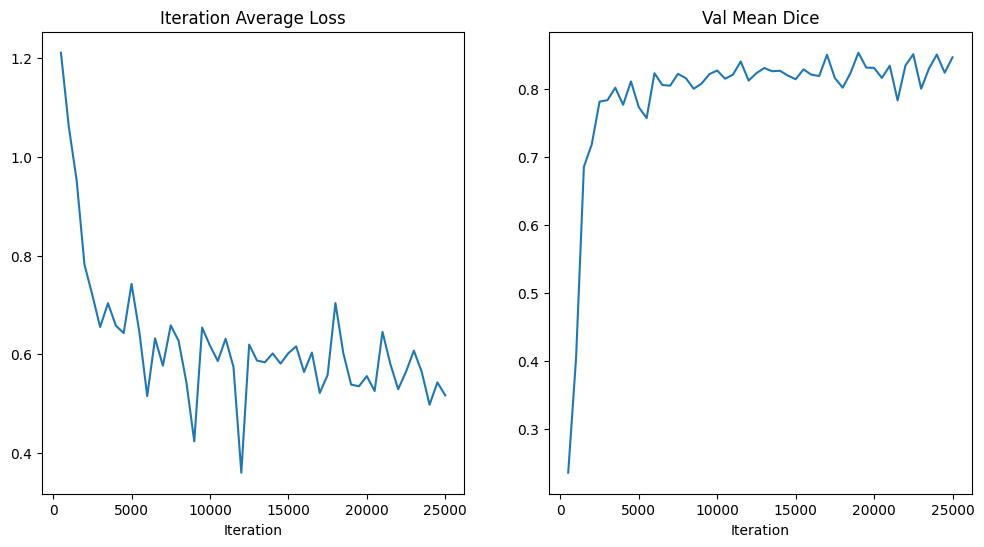

In [10]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()